Testing for applying DeepImageRecon to slices of images, rather than volumes.

In [9]:
import nibabel as nb
import numpy as np

In [91]:
# Load test image from file
noisefile = './test_data/subj_1/AX_Flair_Clear.nii.gz'
truthfile = './test_data/subj_1/T2_Flair_Sense.nii.gz'

In [60]:
list_augments = []
num_augment_flipxy = 2
num_augment_flipx = 2
num_augment_flipy = 2
num_augment_shiftx = 1
num_augment_shifty = 1


for flipxy in range(num_augment_flipxy):
    for flipx in range(num_augment_flipx):
        for flipy in range(num_augment_flipy):
            for shiftx in range(num_augment_shiftx):
                for shifty in range(num_augment_shifty):
                    augment={'flipxy':flipxy,'flipx':flipx,'flipy':flipy,'shiftx':shiftx,'shifty':shifty}
                    list_augments.append(augment)
num_augment=len(list_augments)
print('Will augment data with {0} augmentations.\n'.format(num_augment))
print('List augments:')
list_augments

Will augment data with 8 augmentations.

List augments:


[{'flipx': 0, 'flipxy': 0, 'flipy': 0, 'shiftx': 0, 'shifty': 0},
 {'flipx': 0, 'flipxy': 0, 'flipy': 1, 'shiftx': 0, 'shifty': 0},
 {'flipx': 1, 'flipxy': 0, 'flipy': 0, 'shiftx': 0, 'shifty': 0},
 {'flipx': 1, 'flipxy': 0, 'flipy': 1, 'shiftx': 0, 'shifty': 0},
 {'flipx': 0, 'flipxy': 1, 'flipy': 0, 'shiftx': 0, 'shifty': 0},
 {'flipx': 0, 'flipxy': 1, 'flipy': 1, 'shiftx': 0, 'shifty': 0},
 {'flipx': 1, 'flipxy': 1, 'flipy': 0, 'shiftx': 0, 'shifty': 0},
 {'flipx': 1, 'flipxy': 1, 'flipy': 1, 'shiftx': 0, 'shifty': 0}]

**list_augments** are various transformations to apply to each slice of the input data.  flipx / flipy flip the image over each respective axis.  flipxy flips the image over both axes.  shiftx / shifty shifts the images by the parameterized number of voxels.

In [80]:
def prepare_data_from_nifti(data_path, list_augments=[], scale_by_norm=True, slices=None):
    
    """
    Parameters:
    - - - - -
        data_volume: input volume
        list_augments: types of volumetric transformations to apply (flipx/y, flipxy, shiftx/y)
        scale_by_norm: normalize the volume data
        slices: specific slices to augment. |slices| = number of slices in original volume Z-dimension.
    """
    
    # get nifti
    nib_load = nb.load(data_path)
    
    # get volume data
    data_volume = nib_load.get_data()

    # transpose to slice*x*y*channel
    if np.ndim(data_volume)==3:
        data_volume = data_volume[:,:,:,np.newaxis]
    data_volume = np.transpose(data_volume, [2,0,1,3])
    
    # scale
    if scale_by_norm:
        data_volume = data_volume / np.linalg.norm(data_volume.flatten())

    # extract slices
    if slices is not None:
        data_volume = data_volume[slices,:,:,:]

    # finish loading data
    # print('loaded from {0}, data size {1} (sample, x, y, channel)'.format(path_load, data_load.shape))    
    
    # augmentation
    if len(list_augments)>0:
        
        list_data = []
        
        for augment in list_augments:
            data_augmented = augment_data(data_volume, axis_xy = [1,2], augment = augment)
            list_data.append(data_augmented.reshape(data_volume.shape))
        data_volume = np.concatenate(list_data, axis = 0)
        
    return data_volume


def augment_data(data_xy, axis_xy=[1,2], augment={'flipxy':0,'flipx':0,'flipy':0}):

    # flip over x axis and y axis
    if 'flipxy' in augment and augment['flipxy']:
        data_xy = np.swapaxes(data_xy, axis_xy[0], axis_xy[1])

    # flip over x axis
    if 'flipx' in augment and augment['flipx']:
        if axis_xy[0] == 0:
            data_xy = data_xy[::-1,...]
        if axis_xy[0] == 1:
            data_xy = data_xy[:, ::-1,...]

    # flip over y axis
    if 'flipy' in augment and augment['flipy']:
        if axis_xy[1] == 1:
            data_xy = data_xy[:, ::-1,...]
        if axis_xy[1] == 2:
            data_xy = data_xy[:, :, ::-1,...]

    # shift in x axis
    if 'shiftx' in augment and augment['shiftx']>0:
        if axis_xy[0] == 0:
            data_xy[:-augment['shiftx'],...] = data_xy[augment['shiftx']:,...]
        if axis_xy[0] == 1:
            data_xy[:,:-augment['shiftx'],...] = data_xy[:,augment['shiftx']:,...]

    # shift in y axis
    if 'shifty' in augment and augment['shifty']>0:
        if axis_xy[1] == 1:
            data_xy[:,:-augment['shifty'],...] = data_xy[:,augment['shifty']:,...]
        if axis_xy[1] == 2:
            data_xy[:,:,:-augment['shifty'],...] = data_xy[:,:,augment['shifty']:,...]
    
    return data_xy

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

In [75]:
data_train_input = prepare_data_from_nifti(imagefile,list_augments)
print('Full volume augmentation shape: {:}'.format(data_train_input.shape))

data augmentation
Full volume augmentation shape: (240, 560, 560, 1)


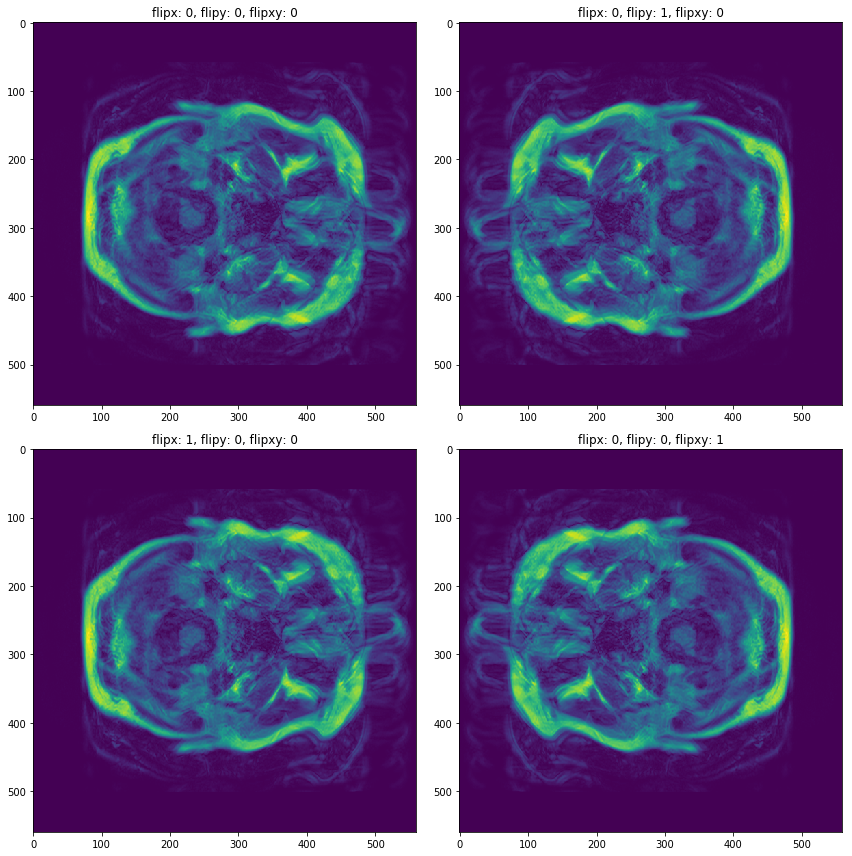

In [76]:
figure,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,12))
ax1.imshow(data_train_input[0,:,:,0]);
ax1.set_title('flipx: 0, flipy: 0, flipxy: 0');
ax2.imshow(data_train_input[30,:,:,0]);
ax2.set_title('flipx: 0, flipy: 1, flipxy: 0');
ax3.imshow(data_train_input[60,:,:,0]);
ax3.set_title('flipx: 1, flipy: 0, flipxy: 0');
ax4.imshow(data_train_input[90,:,:,0]);
ax4.set_title('flipx: 0, flipy: 0, flipxy: 1');

plt.tight_layout()

In [77]:
slice_1 = prepare_data_from_nifti(imagefile,list_augments,slices=[2])
print('Single-slice augmentation shape: {:}'.format(slice_1.shape))

data augmentation
Single-slice augmentation shape: (8, 560, 560, 1)


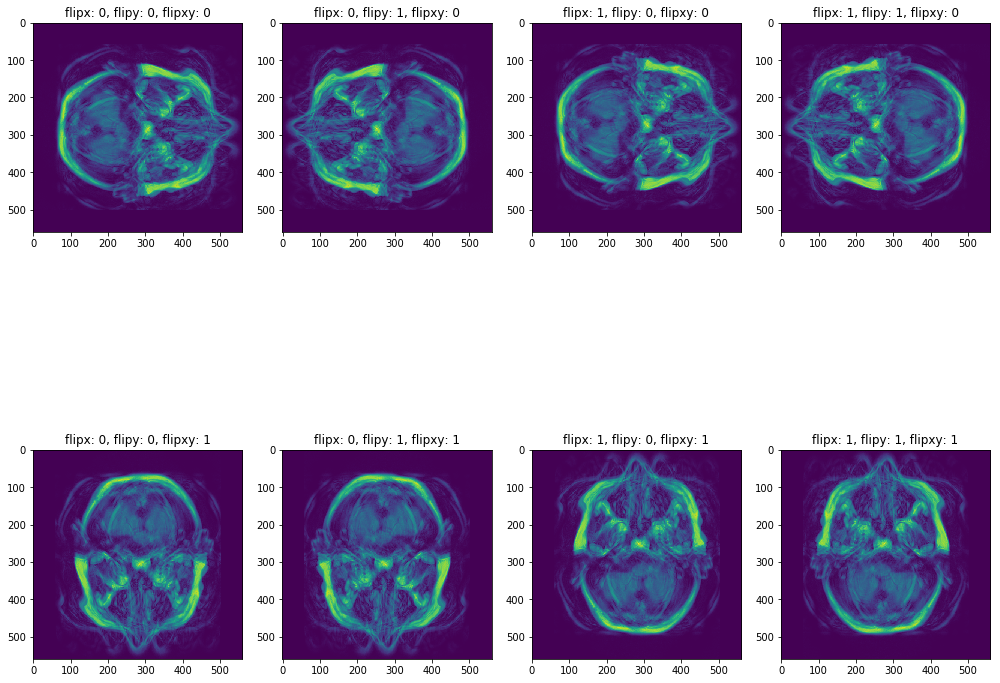

In [78]:
figure,((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4,figsize=(14,14))
ax1.imshow(slice_1[0,:,:,0]);
ax1.set_title('flipx: 0, flipy: 0, flipxy: 0');
ax2.imshow(slice_1[1,:,:,0]);
ax2.set_title('flipx: 0, flipy: 1, flipxy: 0');
ax3.imshow(slice_1[2,:,:,0]);
ax3.set_title('flipx: 1, flipy: 0, flipxy: 0');
ax4.imshow(slice_1[3,:,:,0]);
ax4.set_title('flipx: 1, flipy: 1, flipxy: 0');
ax5.imshow(slice_1[4,:,:,0]);
ax5.set_title('flipx: 0, flipy: 0, flipxy: 1');
ax6.imshow(slice_1[5,:,:,0]);
ax6.set_title('flipx: 0, flipy: 1, flipxy: 1');
ax7.imshow(slice_1[6,:,:,0]);
ax7.set_title('flipx: 1, flipy: 0, flipxy: 1');
ax8.imshow(slice_1[7,:,:,0]);
ax8.set_title('flipx: 1, flipy: 1, flipxy: 1');

plt.tight_layout()

In [92]:
noise_train = []
truth_train = []
for k in np.arange(z):
    noise_train.append(prepare_data_from_nifti(noisefile,list_augments,slices=[k]))
    truth_train.append(prepare_data_from_nifti(truthfile,list_augments,slices=[k]))
    
print('Length noise training slices: {:}'.format(len(noise_train)))
print('Length noise training slices: {:}'.format(len(truth_train)))

Length noise training slices: 30
Length noise training slices: 30


In [93]:
# generate and scale dataset    
scale_data = 100.
data_train_input = scale_data * np.concatenate(noise_train, axis = 0)
data_train_gt = scale_data * np.concatenate(truth_train, axis = 0)    
data_train_residual = data_train_gt - data_train_input
print('mean, min, max')
print(np.mean(data_train_input.flatten()),np.min(data_train_input.flatten()),np.max(data_train_input.flatten()))
print(np.mean(data_train_gt.flatten()),np.min(data_train_gt.flatten()),np.max(data_train_gt.flatten()))
print(np.mean(data_train_residual.flatten()),np.min(data_train_residual.flatten()),np.max(data_train_residual.flatten()))
print('generate train dataset with augmentation size {0},{1}'.format(
	data_train_input.shape, data_train_gt.shape))

mean, min, max
(0.018469211548872228, 0.0, 0.18957323827149758)
(0.0173180109817283, 0.0, 0.3111756534601273)
(-0.001151200567143934, -0.16804906380624643, 0.2666311220629995)
generate train dataset with augmentation size (240, 560, 560, 1),(240, 560, 560, 1)


In [97]:
'''
setup parameters
'''
# related to model
num_poolings = 3
num_conv_per_pooling = 3
# related to training
lr_init = 0.001
#num_epoch = 100
ratio_validation = 0.1
batch_size = 4
# default settings
num_channel_input = data_train_input.shape[-1]
num_channel_output = data_train_gt.shape[-1]
img_rows = data_train_input.shape[1]
img_cols = data_train_gt.shape[1]
keras_memory = 0.4
keras_backend = 'tf'
with_batch_norm = True
print('setup parameters')
print('num input channels: {:}'.format(num_channel_input))
print('num output channels: {:}'.format(num_channel_output))
print('num image rows: {:}'.format(img_rows))
print('num image cols: {:}'.format(img_cols))

setup parameters
num input channels: 1
num output channels: 1
num image rows: 560
num image cols: 560
